# Rolling Evaluation

> This notebook aims to put some concrete form to the ideas we discussed at last Monday's HyMind session (cf. this [ticket](https://app.zenhub.com/workspaces/hylevel-5fd9c347f6ff6d001d15c6a4/issues/hylode/hymind/1)). 
>
> This may be well wide of what you had in mind, but that would be no bad thing -- as long as it's bringing us onto the same page, I'm very happy for this to serve as a straw man.
> 
> What follows uses extremely simplified modelling assumptions and no real data, but what that 'travelling light' mindset buys is simplicity and speed in taking the idea from end to end. 
>
> I'm hoping that layering on the complexity and subbing in the real data won't be too fiendishly tricky. And that having something short and simple will make it easier to discuss as a group.
>
> Here I consider a very simple case. Trying to run HyML and HyDemand models on an 8 patient ICU. 

In [4]:
# start by importing some standard libraries
import random
import pandas as pd
import numpy as np
import sympy as sym
from sklearn.metrics import brier_score_loss, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# and also some odds and ends from a utils module, tk_utils2
from tk_utils2 import pred_at_t_,one_hot,build_expression,pred_on_admission,s,r,syms

## HyML Prediction & Evaluation

As first steps, let's:

1. define a trivially simple patient-level LoS prediction (*made on admission)

2. evaluate those predictions against patients discharged over the past week

3. implement a simple function that predicts an individual's remaining LoS at t (*which may be a while after admission) 


#### An ultra simple predictor

Let's start with a trivially simple prediction for LoS at time of admission - a 50% chance of discharge within each of 2-3 days and 3-4 days:

In [5]:
pred_on_admission

[0, 0, 0.5, 0.5, 0, 0]

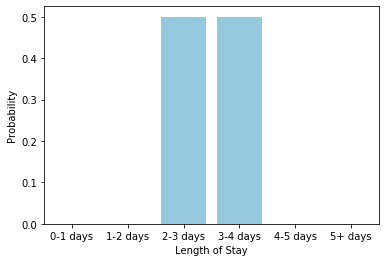

In [6]:
time_windows = ['0-1 days','1-2 days','2-3 days','3-4 days','4-5 days','5+ days']
pred = pd.DataFrame(pred_on_admission, index=time_windows)
# pred.T
b = sns.barplot(data = pred.reset_index(),x='index',y=0, color="skyblue")
b.set(xlabel='Length of Stay', ylabel='Probability');

#### Evaluating HyML (patient-level prediction)

From here, we can imagine running a very simple script to evaluate this predictive model across patient discharged in the last week:

In [7]:
# take 11 as an arbitrary number of discharges over the last week
discharges = 11

In [8]:
# create something that looks like a list of discharged mrns and their respective lengths of stay 
# we restrict ourselves to whole day lengths-of-stay for simplicity
ICU_discharges_this_week = pd.DataFrame(columns=['mrn','los'])
ICU_discharges_this_week['mrn'] = pd.Series(random.sample(range(100,200), discharges))
ICU_discharges_this_week['los'] = np.random.randint(1,5,size=(discharges))
ICU_discharges_this_week

,mrn,los
0,182,3
1,177,1
2,169,1
3,100,1
4,101,2
5,184,4
6,156,2
7,170,1
8,133,2
9,145,3


In [9]:
# evaluate these actual length of stays against our trivially simple model predictions
ICU_discharges_this_week['los_hot'] = ICU_discharges_this_week['los'].apply(one_hot)
ICU_discharges_this_week['predicted_los'] = [pred_on_admission]*discharges
ICU_discharges_this_week['log_loss'] = np.vectorize(log_loss)(ICU_discharges_this_week['los_hot'],ICU_discharges_this_week['predicted_los'])
ICU_discharges_this_week

,mrn,los,los_hot,predicted_los,log_loss
0,182,3,"[0, 0, 0, 1, 0, 0]","[0, 0, 0.5, 0.5, 0, 0]",0.231049
1,177,1,"[0, 1, 0, 0, 0, 0]","[0, 0, 0.5, 0.5, 0, 0]",5.987512
2,169,1,"[0, 1, 0, 0, 0, 0]","[0, 0, 0.5, 0.5, 0, 0]",5.987512
3,100,1,"[0, 1, 0, 0, 0, 0]","[0, 0, 0.5, 0.5, 0, 0]",5.987512
4,101,2,"[0, 0, 1, 0, 0, 0]","[0, 0, 0.5, 0.5, 0, 0]",0.231049
5,184,4,"[0, 0, 0, 0, 1, 0]","[0, 0, 0.5, 0.5, 0, 0]",5.987512
6,156,2,"[0, 0, 1, 0, 0, 0]","[0, 0, 0.5, 0.5, 0, 0]",0.231049
7,170,1,"[0, 1, 0, 0, 0, 0]","[0, 0, 0.5, 0.5, 0, 0]",5.987512
8,133,2,"[0, 0, 1, 0, 0, 0]","[0, 0, 0.5, 0.5, 0, 0]",0.231049
9,145,3,"[0, 0, 0, 1, 0, 0]","[0, 0, 0.5, 0.5, 0, 0]",0.231049


In [10]:
# mean Log Loss
ICU_discharges_this_week['log_loss'].mean()

2.847623029498065

#### HyML prediction (patient-level)

As a final step on HyML, we need to adapt out patient-level predictions to reflect that some patients have already been on ICU for some time. (So that we can feed probabilities of remaining LoS into our HyDemand model.) 

To make life simpler we restrict ourselves to whole numbers of days again. Let's begin by generating a random snapshot of the ward at a given time, t:

In [11]:
# create something that looks like a list of mrns
in_ICU_at_t = pd.DataFrame(columns=['mrn','days_since_admit'])
in_ICU_at_t['mrn'] = pd.Series(random.sample(range(100,200), 8))

# with days already spent on ICU as random integers between 0 and 4
in_ICU_at_t['days_since_admit'] = np.random.randint(0,4,size=(8))
in_ICU_at_t

,mrn,days_since_admit
0,127,1
1,116,1
2,176,1
3,194,0
4,166,1
5,160,0
6,108,0
7,143,1


From this starting point, we can generate patient-level predictions of LoS at time t. In tkutils2, I define a straightforward function that shifts across the LoS prediction on admission to reflect the number of days already spent on the unit. 

In [12]:
# effectively, pred_at_t is a simple dynamic LoS model that takes time already spent on ICU as a lone feature.
# inspect code by running ??pred_at_t_ in a separate cell
pred_at_t = lambda x: pred_at_t_(x, in_ICU_at_t)
in_ICU_at_t['patient-level prediction']=in_ICU_at_t['mrn'].apply(pred_at_t)
in_ICU_at_t

,mrn,days_since_admit,patient-level prediction
0,127,1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]"
1,116,1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]"
2,176,1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]"
3,194,0,"[0.0, 0.0, 0.5, 0.5, 0.0, 0.0]"
4,166,1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]"
5,160,0,"[0.0, 0.0, 0.5, 0.5, 0.0, 0.0]"
6,108,0,"[0.0, 0.0, 0.5, 0.5, 0.0, 0.0]"
7,143,1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]"


In [13]:
# where the patient level predictions correspond to the time-windows above, but for remaining length of stay, cf.
pd.DataFrame(in_ICU_at_t.iloc[0]['patient-level prediction'],index=time_windows).T

,0-1 days,1-2 days,2-3 days,3-4 days,4-5 days,5+ days
0,0.0,0.5,0.5,0.0,0.0,0.0


## HyDemand Prediction & Evaluation

#### HyDemand Prediction (aggregate)

Okay.. so from the previous section, we have patient-level predictions of remaining LoS for all the patient on ICU at t. We now want to use Martin's equations to forecast aggregate demand.

In particular, here we try to predict 'of the 8 patients currently on the unit, how many will still be on the unit in two days time?'

In [14]:
# my approach has been to us sympy to build up the expression we need from Martin's paper
# the code for this is in tk_utils2.py
expression = build_expression()
expression

(r0*s - r0 + 1)*(r1*s - r1 + 1)*(r2*s - r2 + 1)*(r3*s - r3 + 1)*(r4*s - r4 + 1)*(r5*s - r5 + 1)*(r6*s - r6 + 1)*(r7*s - r7 + 1)

In [15]:
# to reach the probabilities of different numbers of beds being optimised we will need to\
# calculate the coefficients of different powers of s in the expression above
def return_coeff(i): return sym.expand(expression).coeff(s,i)
# return_coeff(2)

First let's add a column of patient-level predictions for whether that patient will stay for longer than 2 further days:

In [16]:
in_ICU_at_t['prob >2 days stay'] = in_ICU_at_t['patient-level prediction'].apply(lambda probs: sum(probs[2:]))
in_ICU_at_t

,mrn,days_since_admit,patient-level prediction,prob >2 days stay
0,127,1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]",0.5
1,116,1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]",0.5
2,176,1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]",0.5
3,194,0,"[0.0, 0.0, 0.5, 0.5, 0.0, 0.0]",1.0
4,166,1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]",0.5
5,160,0,"[0.0, 0.0, 0.5, 0.5, 0.0, 0.0]",1.0
6,108,0,"[0.0, 0.0, 0.5, 0.5, 0.0, 0.0]",1.0
7,143,1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]",0.5


We then subsitute these probabilities into r0 through r7 in our expression above:

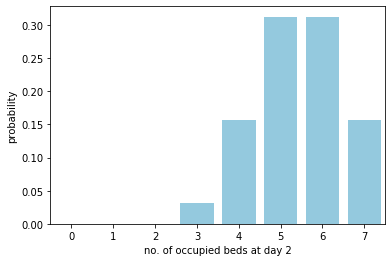

In [17]:
# syms gives r0,r1,r2...
substitution = dict(zip(syms,in_ICU_at_t['prob >2 days stay']))

# using our dictionary 'substitution' above, we return the co-efficients of different powers of s\
# and append them to a list
aggregate_predictions = []
for i in range(8):
    aggregate_predictions.append([i,float(return_coeff(i).subs(substitution))])

# plotting the results 
aggregate_predictions_df = pd.DataFrame(aggregate_predictions, columns=['no. of occupied beds at day 2','probability'])
sns.barplot(data=aggregate_predictions_df, x='no. of occupied beds at day 2',y='probability', color="skyblue")

#### Evaluating HyDemand (aggregate)

Finally, we imagine what it will look like to evaluate these HyDemand predictions:

In [18]:
# create something that looks like the query\ 
# 'of those patients who were on ICU at t, how many are still on 2 days later?'
still_in_at_t_plus_2 = pd.DataFrame(columns=['mrn','still_in'])
still_in_at_t_plus_2['mrn'] = in_ICU_at_t['mrn']

# at this stage, just randomly assign true and false
def flip(p): return False if random.random() < p else True
still_in_at_t_plus_2['still_in'] = np.vectorize(flip)([0.5]*8)
still_in_at_t_plus_2

,mrn,still_in
0,127,False
1,116,False
2,176,True
3,194,True
4,166,False
5,160,False
6,108,True
7,143,False


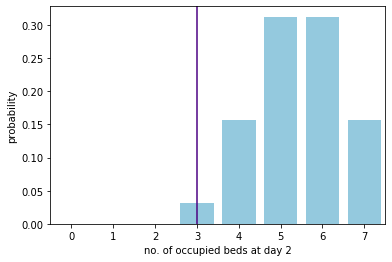

In [19]:
# a simple plot - how did our HyDemand prediction compare to the actual no. of patients still on the unit at t+2
number_still_in = still_in_at_t_plus_2['still_in'].sum()
g = sns.barplot(data=aggregate_predictions_df, x='no. of occupied beds at day 2',y='probability', color="skyblue")
g.axvline(x = number_still_in, color = 'indigo', label = 'axvline - full height') 

In [20]:
# then we set up the one-hot vector to evaluate the HyDemand prediction
def still_in_to_vector(number_still_in): return [1.0 if i==number_still_in else 0.0 for i in range(8)]
aggregate_predictions_df['actual'] = still_in_to_vector(number_still_in)
aggregate_predictions_df

,no. of occupied beds at day 2,probability,actual
0,0,0.00000,0.0
1,1,0.00000,0.0
2,2,0.00000,0.0
3,3,0.03125,1.0
4,4,0.15625,0.0
5,5,0.31250,0.0
6,6,0.31250,0.0
7,7,0.15625,0.0


In [21]:
aggregate_loss = log_loss(list(aggregate_predictions_df['actual']),list(aggregate_predictions_df['probability']))
aggregate_loss

0.5693651094091683

Suggestions for next steps...

- transfer across to EMAP
- run simulation across 30-bed ICU for indication on computation time
- implement the agggregate demand evaluation plot from Pagel et al.
- work up some of the over-simplifications above